Import Emotions Predict Dataset






In [6]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

# Set extract_path to the downloaded path
extract_path = path

print("Path to dataset files:", path)

# Check folder structure
os.listdir(extract_path)

# STEP 3: Set up image paths for training and testing data
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

Path to dataset files: /kaggle/input/fer2013


Dataset Preparation

In [7]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf

# Get the list of emotion folders, excluding "Disgust" if present
folderList = sorted([f for f in os.listdir(train_dir) if f.lower() != 'disgust'])
print("Emotion categories:", folderList)

# Function to load grayscale 48x48 images and corresponding labels from folders
def load_images_from_folder(base_path, folderList):
    data, labels = [], []
    for idx, category in enumerate(folderList):
        category_path = os.path.join(base_path, category)
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            img = Image.open(img_path).convert('L').resize((48, 48))
            data.append(np.array(img))
            labels.append(idx)
    return np.array(data, dtype='float32'), np.array(labels)

# Load and normalize both training and test data
X_train, y_train = load_images_from_folder(train_dir, folderList)
X_test, y_test = load_images_from_folder(test_dir, folderList)

# Normalize pixel values
X_train /= 255.0
X_test /= 255.0

# Reshape data to match CNN input: (samples, height, width, channels)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Convert class labels to one-hot encoded vectors
num_classes = len(folderList)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Emotion categories: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (28273, 48, 48, 1)
Test shape: (7067, 48, 48, 1)


Model Creation

In [8]:
# Build a CNN model (VGGNet architecture)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout to reduce overfitting
    tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,866,438 (22.38 MB)

 Trainable params: 5,866,438 (22.38 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split train into train and validation sets (80% train, 20% val)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Compute class weights to balance the influence of each class during training
y_train_labels = np.argmax(y_train_final, axis=1)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)
class_weights = dict(enumerate(class_weights))

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Create an ImageDataGenerator for augmentation on training data only
datagen = ImageDataGenerator(
    rotation_range=15,          # randomly rotate images by up to 15 degrees
    width_shift_range=0.1,      # randomly shift images horizontally by 10%
    height_shift_range=0.1,     # randomly shift images vertically by 10%
    horizontal_flip=True        # randomly flip images horizontally
)

# Train using the augmented data generator
history = model.fit(
    datagen.flow(X_train_final, y_train_final, batch_size=32),
    validation_data=(X_val, y_val), #use validation from training split
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


707/707 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.1710 - loss: 1.7738 - val_accuracy: 0.2752 - val_loss: 1.6825
Epoch 2/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.2964 - loss: 1.6543 - val_accuracy: 0.4191 - val_loss: 1.5032
Epoch 3/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.3860 - loss: 1.5361 - val_accuracy: 0.4833 - val_loss: 1.3181
Epoch 4/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4352 - loss: 1.4385 - val_accuracy: 0.4932 - val_loss: 1.2867
Epoch 5/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.4793 - loss: 1.3502 - val_accuracy: 0.5250 - val_loss: 1.2177
Epoch 6/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5175 - loss: 1.2870 - val_accuracy: 0.5379 - val_loss: 1.1825
Epoch 7/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5213 - loss: 1.2541 - val_accuracy: 0.5632 - val_loss: 1.1277
Epoch 8/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5422 - loss: 1.1988 - val_accurac

Evaluation and Visualization

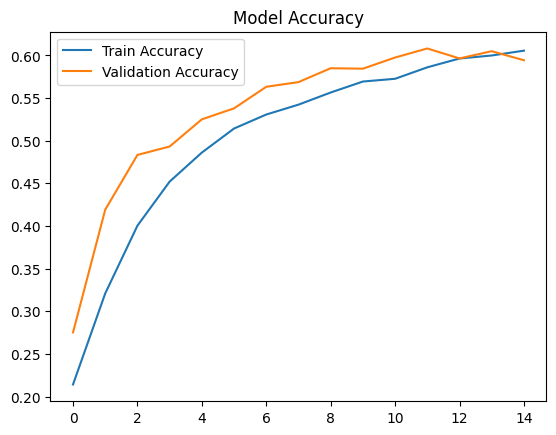

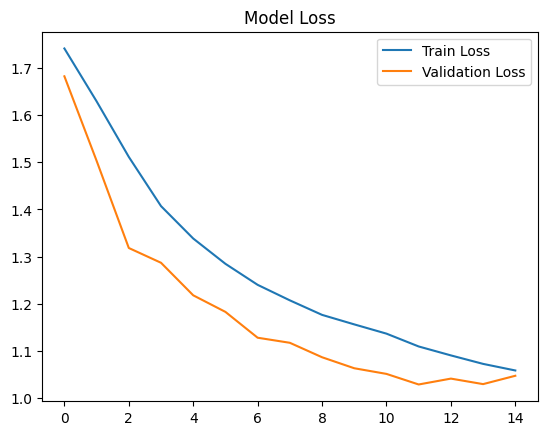

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

Confusion Matrix and Classification Report

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


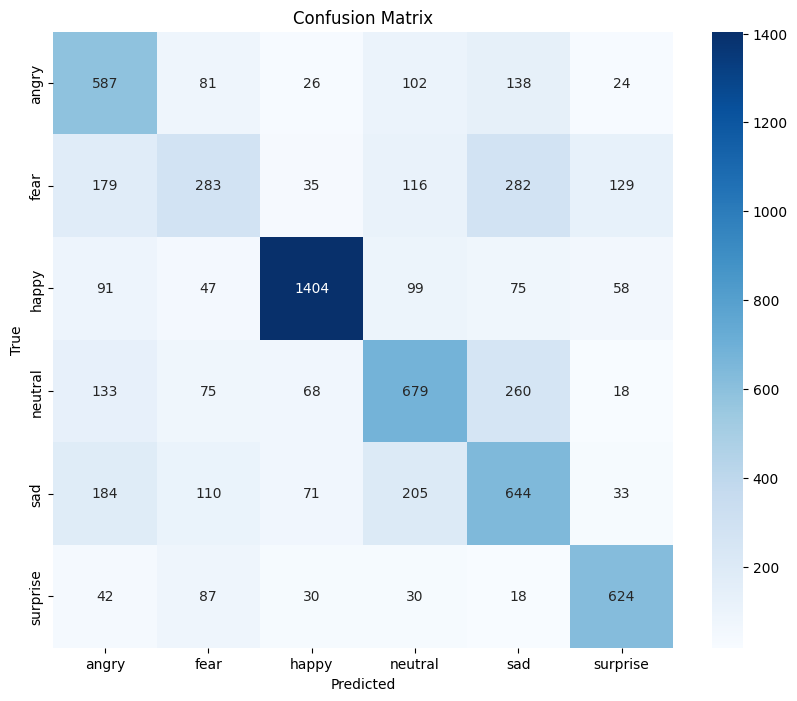

Classification Report:

              precision    recall  f1-score   support

       angry       0.48      0.61      0.54       958
        fear       0.41      0.28      0.33      1024
       happy       0.86      0.79      0.82      1774
     neutral       0.55      0.55      0.55      1233
         sad       0.45      0.52      0.48      1247
    surprise       0.70      0.75      0.73       831

    accuracy                           0.60      7067
   macro avg       0.58      0.58      0.58      7067
weighted avg       0.60      0.60      0.60      7067



In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict class probabilities on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert probabilities to class indices
y_true_classes = np.argmax(y_test, axis=1) # Convert one-hot to class indices

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=folderList, yticklabels=folderList, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

# Print classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=folderList)
print("Classification Report:\n")
print(report)

Prediction Testing

A file dialog will appear below. Select and upload your image file.


Saving Screenshot (96).png to Screenshot (96).png
User uploaded image file 'Screenshot (96).png'

Face cascade loaded successfully.

--- Starting Face Detection on 'Screenshot (96).png' ---
Found 1 face(s) in the image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


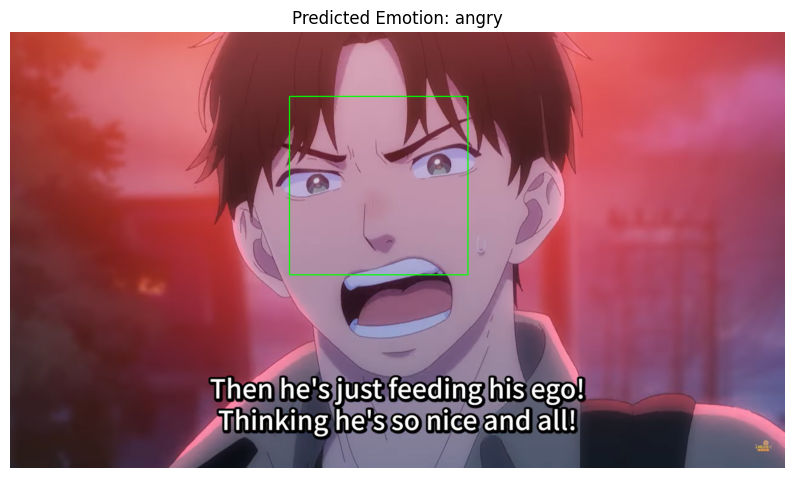

Results saved as 'Screenshot (96)_faces_detected.png'


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #For displaying images in Colab output
from google.colab import files # For file upload
import os #For file path manipulation

print ("A file dialog will appear below. Select and upload your image file.")

uploaded_image = files.upload()  #This will open a file dialog in your browser

image_file_name = None
if uploaded_image:
  for fn in uploaded_image.keys():
    image_file_name = fn  # Get the name of the uploaded image file
    print(f"User uploaded image file '{image_file_name}'")
else:
    print("No image file was uploaded. Skipping this section.")

if image_file_name:
    # --- Load the pre-trained Haar Cascade for face detection ---
    print("\nDownloading Haar Cascade classifier for face detection...")
    # This downloads the XML file containing the pre-trained features for frontal face detection.
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    if face_cascade.empty():
        print("Error: Could not load face cascade classifier. Make sure 'haarcascade_frontalface_default.xml' is available.")
        print("Skipping image processing.")
    else:
        print("Face cascade loaded successfully.")

    # --- Load the uploaded image ---
    img = cv2.imread(image_file_name)

    if img is None:
        print(f"Error: Could not read image file '{image_file_name}'. Please check the file format and integrity.")
    else:
        print(f"\n--- Starting Face Detection on '{image_file_name}' ---")

        # Convert the image to grayscale for face detection (Haar cascades work on grayscale)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        # scaleFactor: Parameter specifying how much the image size is reduced at each image scale.
        #               (e.g., 1.1 means scale down by 10% each time)
        # minNeighbours: Parameter specifying how many neighbours each candidate rectangle should have to retain
        # minSize : Minimum possible object size. Objects smaller than that are ignored.
        faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        print(f"Found {len(faces)} face(s) in the image.")

        # Create a copy of the original image to draw on
        output_img = img.copy()

        # Draw rectangles around the detected faces
        for (x, y, w, h) in faces:
          # cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
          cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle, thickness 2

        # Predict the emotion
        # Extract the face region from the grayscale image
        if len(faces) > 0:
            # For simplicity, predict emotion on the first detected face
            (x, y, w, h) = faces[0]
            face_img = gray_img[y:y+h, x:x+w]
            # Resize to 48x48 and normalize
            face_img = Image.fromarray(face_img).resize((48, 48))
            face_img_array = np.array(face_img).astype('float32') / 255.0
            face_img_array = face_img_array.reshape(1, 48, 48, 1) # Reshape for model input

            prediction = model.predict(face_img_array)
            predicted_class = np.argmax(prediction)
            predicted_emotion = folderList[predicted_class]
        else:
            predicted_emotion = "No face detected"

        # --- Display Results ---
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
        plt.title(f"Predicted Emotion: {predicted_emotion}")
        plt.axis('off')
        plt.show()

        # You can also save the results if needed
        base_name = os.path.splitext(image_file_name)[0]
        cv2.imwrite(f'{base_name}_faces_detected.png', output_img)
        print(f"Results saved as '{base_name}_faces_detected.png'")

else:
    print("Image face detection skipped. Please upload an image file if you wish to run this section.")

Here are some potential next steps for deploying your emotion prediction model:

1.  **Save the trained model:** (This has already been done in the previous cell, saving it in the `.keras` format.)
2.  **Download the saved model:** You'll need to download the saved model file (`emotion_model.keras`) from your Colab environment to your local machine or a deployment server.
3.  **Create a Flask/Django application:** Set up the basic structure of your web application using a framework like Flask or Django.
4.  **Implement the upload and prediction logic:** Write code within your web application to handle file uploads, load the saved model, preprocess the image, perform face detection and emotion prediction, and return the result.
5.  **Create HTML templates:** Design the web page for image upload and displaying results.

**Example (Flask - Simplified):**

In [13]:
# Save the trained model in TensorFlow's SavedModel format
model.save('emotion_model.keras')
print("Model saved successfully in SavedModel format.")

# To save in HDF5 format (another common format)
# model.save('emotion_model.h5')
# print("Model saved successfully in HDF5 format.")

# You can then download this saved model file(s) from Colab
from google.colab import files
try:
  files.download('emotion_model.keras')
  print("\nDownloading emotion_model.keras...")
except Exception as e:
  print(f"Error downloading file: {e}")

# If saved as SavedModel (a directory), you'll need to zip and download the entire directory
# import shutil
# shutil.make_archive('emotion_model_savedmodel', 'zip', 'emotion_model')
# print("\nDownloading emotion_model_savedmodel.zip...")
# files.download('emotion_model_savedmodel.zip')

Model saved successfully in SavedModel format.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# prompt: deploy this to github

import io
from google.colab import output

# Get the content of the current notebook as a string
# This command executes JavaScript in the browser to get the notebook content
js_code = '''
jupyter_notebook = Jupyter.notebook;
var cells = jupyter_notebook.get_cells();
var code = '';
cells.forEach(function(cell){
  if (cell.cell_type === 'code') {
    code += cell.get_text() + '\\n\\n'; // Append cell content and add separation
  }
});
return code;
'''

code_content = output.eval_js(js_code)

# Define the filename
python_filename = 'emotion_predictor.py'

# Write the code content to a Python file
with open(python_filename, 'w') as f:
    f.write(code_content)

print(f"Notebook code saved to {python_filename}")

# You can then download the file
try:
  files.download(python_filename)
  print(f"\nDownloading {python_filename}...")
except Exception as e:
  print(f"Error downloading file: {e}")

# After downloading, you would manually add this file to your local Git repository,
# commit it, and push it to your GitHub repository.

# Example shell commands you would run *outside* of Colab in your terminal:
# git add emotion_predictor.py
# git commit -m "Add emotion predictor code from Colab notebook"
# git push origin main # Or your branch name


MessageError: SyntaxError: Illegal return statement